In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
from subprocess import call

np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [21]:
filename = 'Localized_N=100000_S=200_M=40_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=40_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [10]:
filename = 'Localized_N=100000_S=200_M=40_G=20_model.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading model from: " + filepath
f = open(filepath, 'rb')
options = cPickle.load(f)
model = cPickle.load(f)
seq_model = cPickle.load(f)
ground_truth = cPickle.load(f)
f.close()

loading model from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=40_G=20_model.pickle


In [11]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [12]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=0, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.94703 -- accuracy=92.98%  
  valid loss:		0.74689
  valid accuracy:	0.95013+/-0.02551
  valid auc-roc:	0.88719+/-0.11564
  valid auc-pr:		0.49623+/-0.33453
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=40_G=20_model.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.64688 -- accuracy=95.61%  
  valid loss:		0.50957
  valid accuracy:	0.96585+/-0.02090
  valid auc-roc:	0.94823+/-0.07736
  valid auc-pr:		0.67016+/-0.31415
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=40_G=20_model.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.44559 -- accuracy=96.56%  
  valid loss:		0.34797
  valid accuracy:	0.97273+/-0.02060
  valid auc-roc:	0.96379+/-0.06253
  valid auc-pr:		0.73306+/-0.29196
saving model parameters to: /home/peter/D

In [ ]:
#epoch = 111
#savepath = filepath + "_epoch_" + str(epoch) + ".pickle"
#nnmodel.set_parameters_from_file(savepath)

In [14]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7fda75b7b510>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fda75d10d10>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7fda6fe7b190>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7fda75b7b3d0>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fda6feec0d0>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7fda6feec110>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7fda6feece10>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7fda6feec390>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7fda6feec150>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fda75aff2d0>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7fda75aff310>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fdad810d810>,
 'dense1_bias': <lasagne.layers.special.BiasLayer at 0x7fda75aff350>,
 'dense1_dropout': <lasagne.layers.noise.DropoutLayer at

In [15]:

def get_output(X,layer):
    num_data = len(X)
    feature_maps = theano.function([nnmodel.input_var], layers.get_output(layer,deterministic=True), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    output = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        output[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        output[index] = feature_maps(X[index])
    return output


X = train[0]
layer = network['output']
output = get_output(X,layer)
output2 = get_output(test[0],layer)


In [16]:
output2

array([[  5.17836997e-05,   1.16250871e-04,   4.76580142e-04, ...,
          2.09485079e-05,   5.61191468e-04,   2.85712350e-03],
       [  1.44536871e-05,   3.81943464e-05,   8.86628823e-06, ...,
          9.99849677e-01,   1.96090350e-05,   9.37456280e-05],
       [  2.77149138e-05,   7.87361496e-05,   9.97853458e-01, ...,
          7.78189019e-07,   5.40608635e-05,   5.76813763e-04],
       ..., 
       [  3.15234880e-04,   8.64976610e-05,   2.95690319e-04, ...,
          2.55088583e-02,   9.24002452e-05,   7.03479513e-04],
       [  1.19073295e-04,   8.92243385e-01,   1.02366699e-04, ...,
          4.20620083e-04,   8.03859206e-04,   6.89298438e-04],
       [  9.88257816e-04,   4.43492550e-03,   1.06968416e-03, ...,
          3.19648185e-04,   2.22937809e-03,   5.88213676e-04]])

In [17]:
shape2 = list(output.shape)
shape2[0] = None
input_var2 = T.dmatrix('input')
input_var2 = T.cast(input_var2, 'float32')


deconv = {}
deconv['input'] = InputLayer(tuple(shape2), input_var=input_var2)
num_units = list(get_output_shape(network['dense1']))[1]
deconv['dense2'] = layers.DenseLayer(deconv['input'], num_units=num_units, W=network['dense2'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=nonlinearities.rectify)
num_units = np.prod(list(get_output_shape(network['conv2_pool']))[1:])
deconv['dense1'] = layers.DenseLayer(deconv['dense2'], num_units=num_units, W=network['dense1'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=nonlinearities.rectify)

shape = list(get_output_shape(network['conv2_pool']))
shape[0] = -1
deconv['reshape'] = layers.ReshapeLayer(deconv['dense1'], shape=tuple(shape))
deconv['pool2'] = layers.Upscale2DLayer(deconv['reshape'], (2,1))
deconv['conv2']  = Conv2DLayer(deconv['pool2'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)

deconv['pool1'] = layers.Upscale2DLayer(deconv['conv2'], (4,1))
deconv['conv1']  = Conv2DLayer(deconv['pool1'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
deconv['output'] = deconv['conv1']

In [18]:
target_var = T.tensor4('targets')
prediction = layers.get_output(deconv['output'], deterministic=False)

loss = (target_var - prediction) ** 2
loss = loss.mean()

params = layers.get_all_params(deconv['output'], trainable=True)    
grad = T.grad(loss, params)

update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var2, target_var], [loss, prediction], updates=update_op)

In [23]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)

batch_size = 128        
for epoch in range(50):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    num_batches = output.shape[0] // batch_size
    batches = batch_generator(output, train[0], batch_size)
    value = 0
    for i in range(num_batches):
        X,y = next(batches)
        loss, prediction = train_fun(X, y)
        value += np.mean(loss)
    sys.stdout.write("\r  loss = %f \n"%(value/num_batches))


Epoch 1 
  loss = 0.177838 
Epoch 2 
  loss = 0.177821 
Epoch 3 
  loss = 0.177804 
Epoch 4 
  loss = 0.177787 
Epoch 5 
  loss = 0.177770 
Epoch 6 
  loss = 0.177754 
Epoch 7 
  loss = 0.177738 
Epoch 8 
  loss = 0.177722 
Epoch 9 
  loss = 0.177707 
Epoch 10 
  loss = 0.177691 
Epoch 11 
  loss = 0.177676 
Epoch 12 
  loss = 0.177661 
Epoch 13 
  loss = 0.177646 
Epoch 14 
  loss = 0.177631 
Epoch 15 
  loss = 0.177617 
Epoch 16 
  loss = 0.177604 
Epoch 17 
  loss = 0.177591 
Epoch 18 
  loss = 0.177576 
Epoch 19 
  loss = 0.177562 
Epoch 20 
  loss = 0.177548 
Epoch 21 
  loss = 0.177536 
Epoch 22 
  loss = 0.177523 
Epoch 23 
  loss = 0.177511 
Epoch 24 
  loss = 0.177499 
Epoch 25 
  loss = 0.177486 
Epoch 26 
  loss = 0.177474 
Epoch 27 
  loss = 0.177462 
Epoch 28 
  loss = 0.177451 
Epoch 29 
  loss = 0.177441 
Epoch 30 
  loss = 0.177430 
Epoch 31 
  loss = 0.177419 
Epoch 32 
  loss = 0.177409 
Epoch 33 
  loss = 0.177398 
Epoch 34 
  loss = 0.177388 
Epoch 35 
  loss = 0.17

In [59]:
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


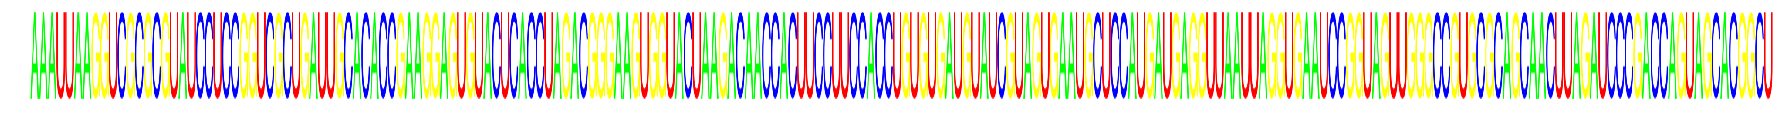

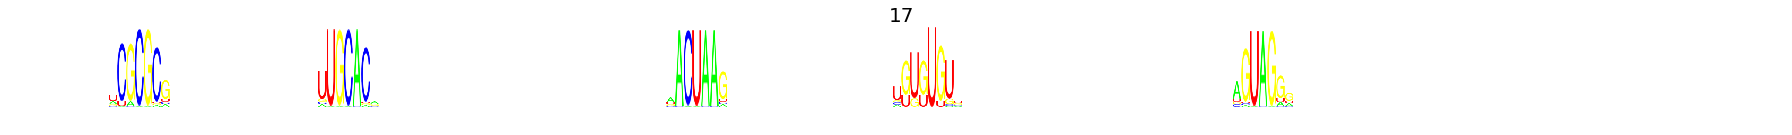

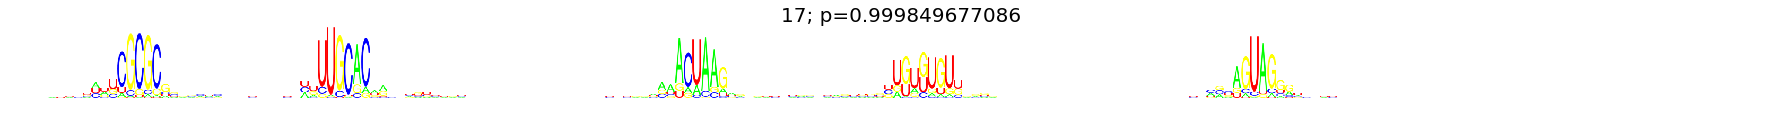

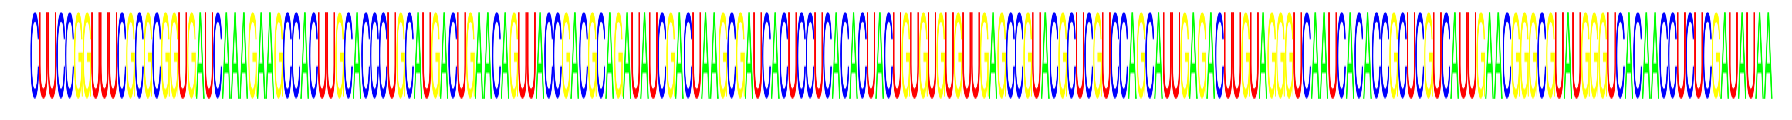

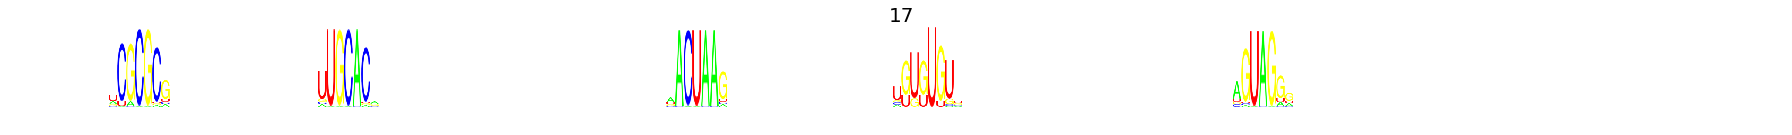

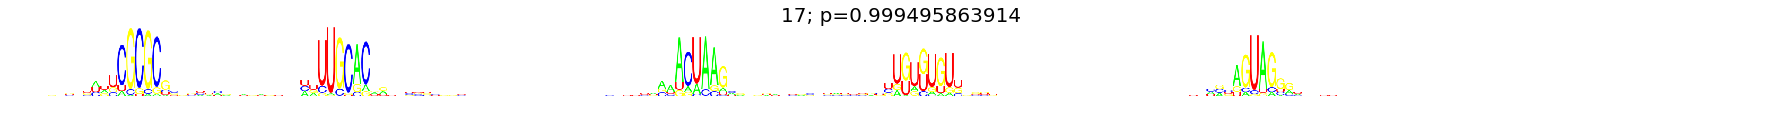

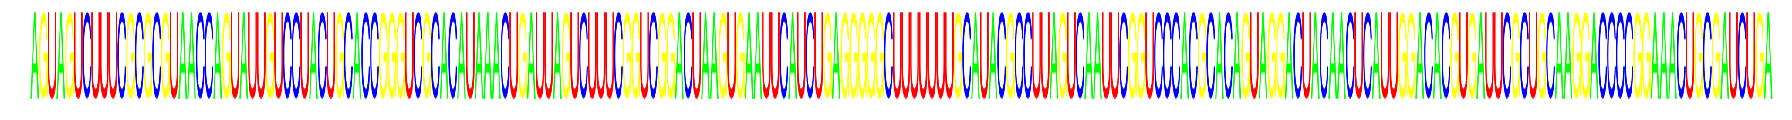

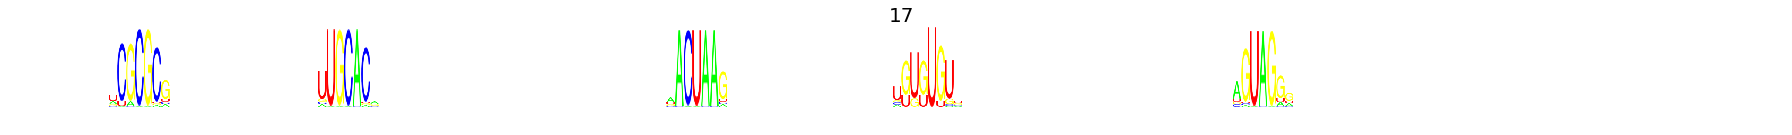

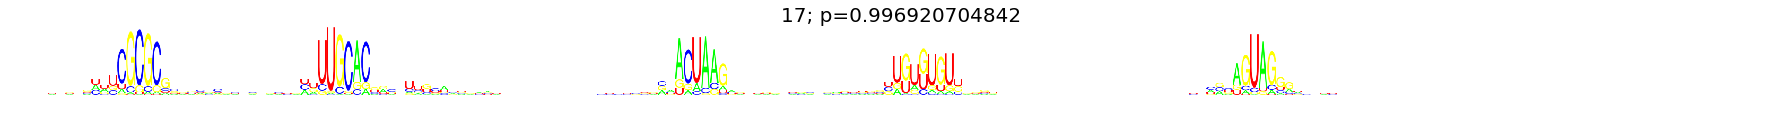

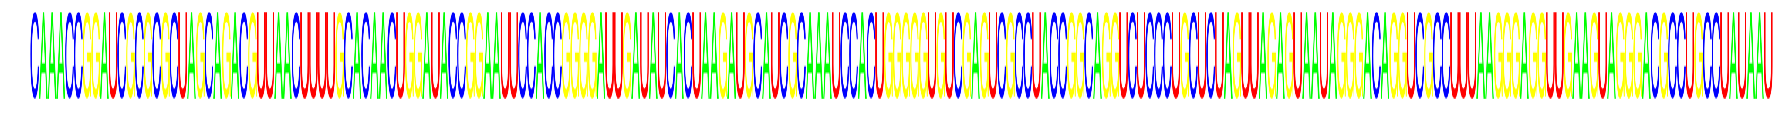

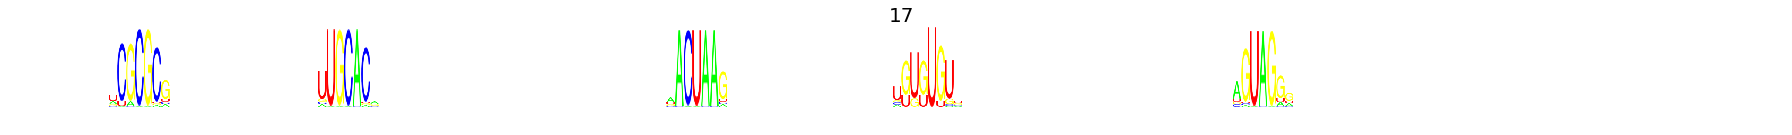

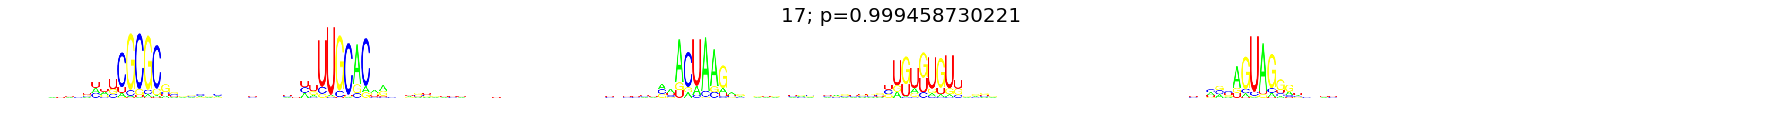

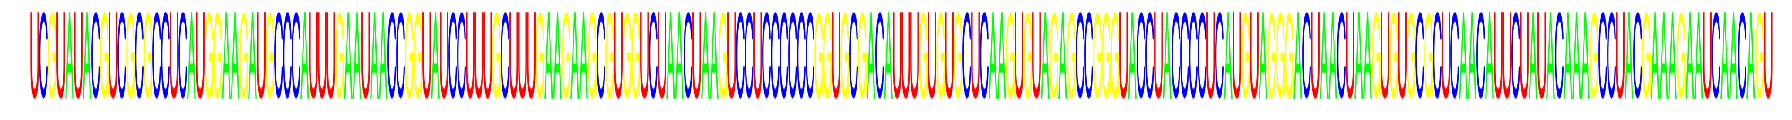

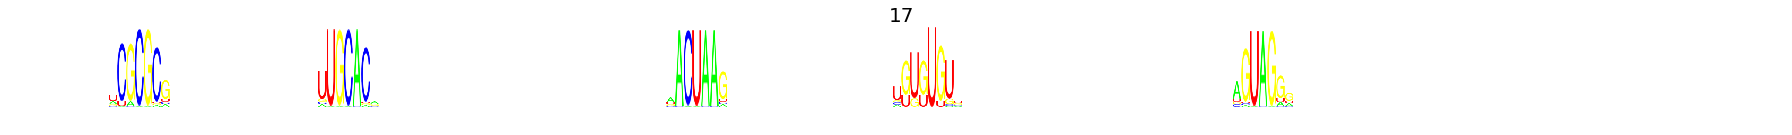

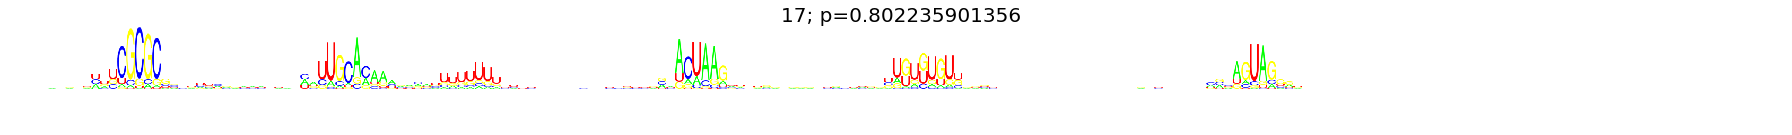

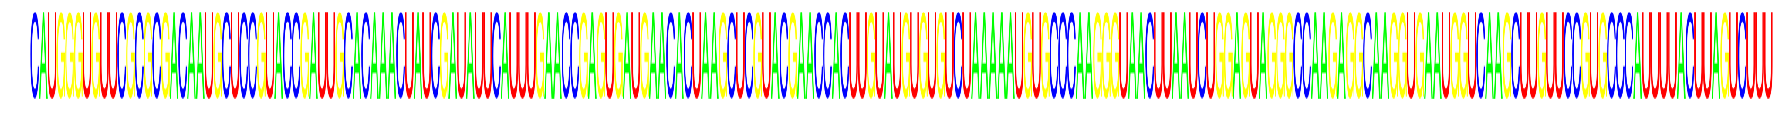

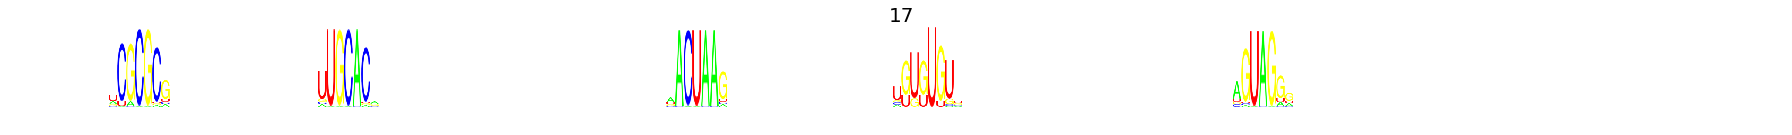

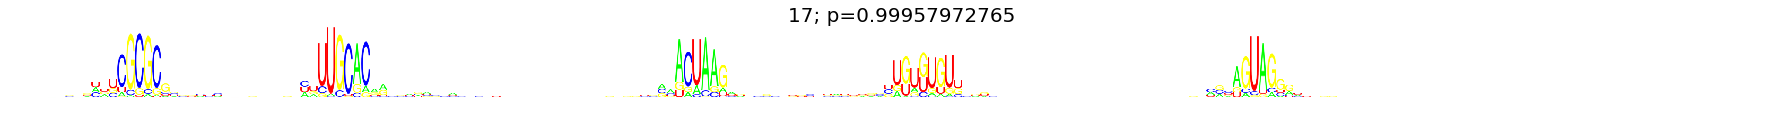

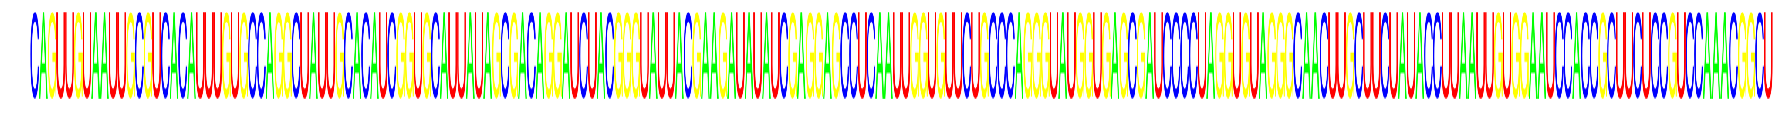

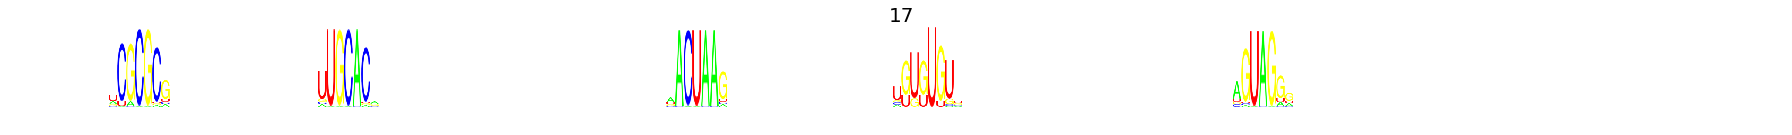

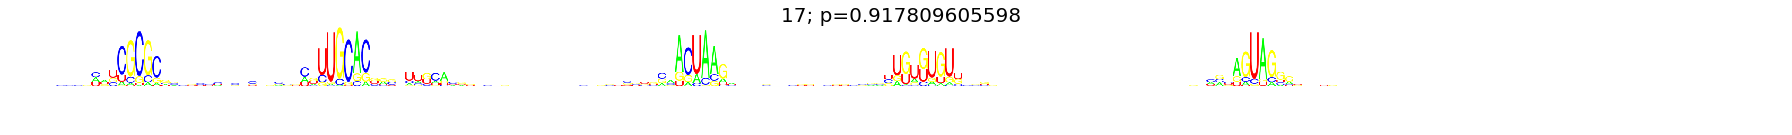

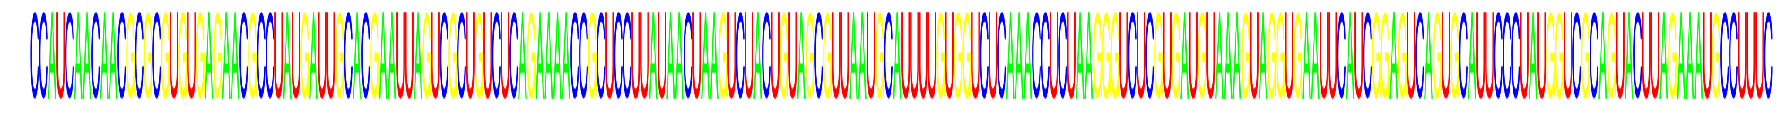

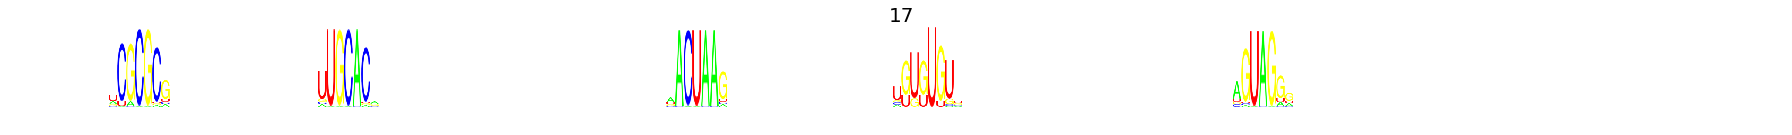

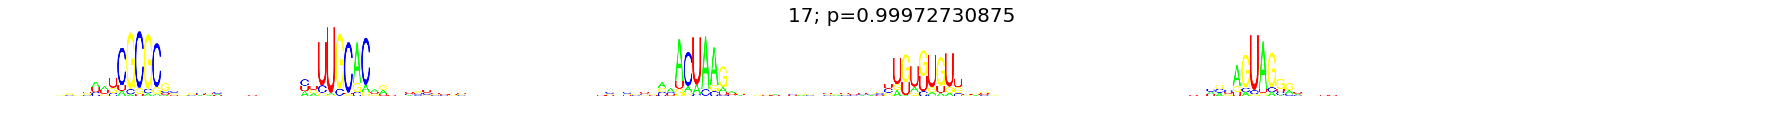

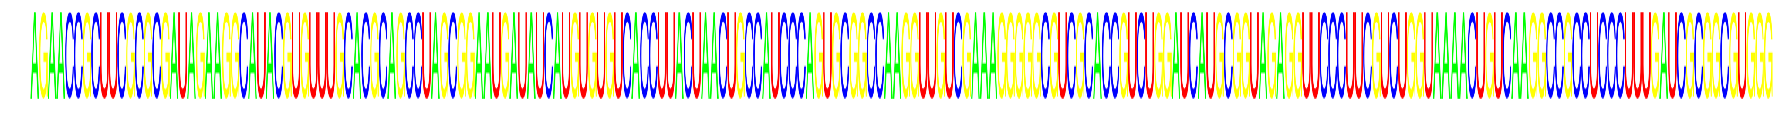

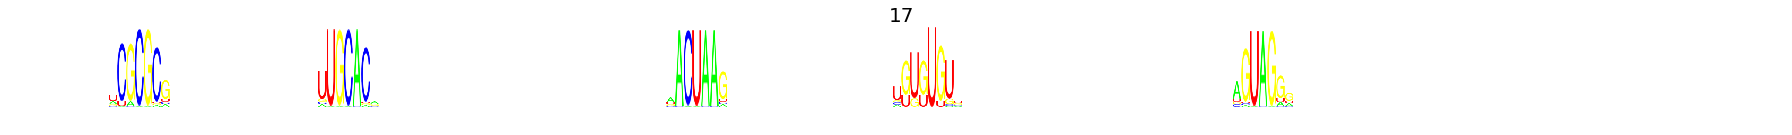

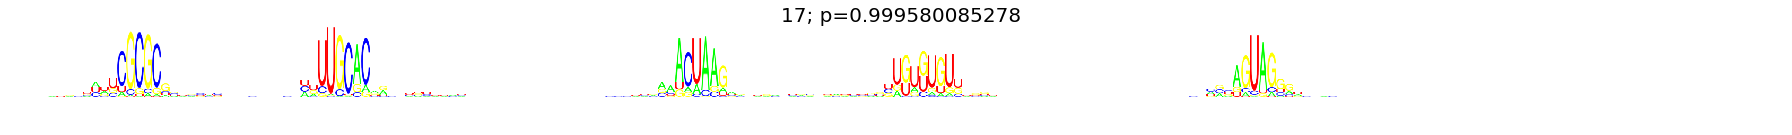

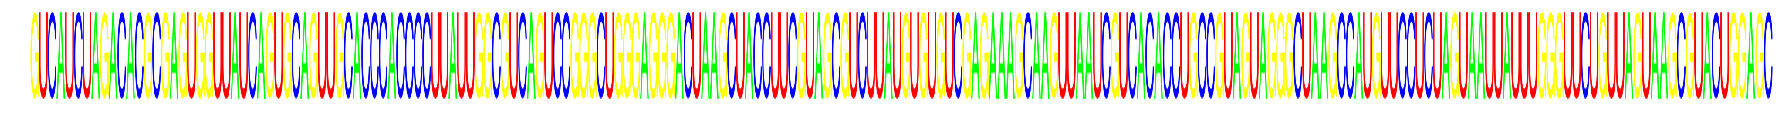

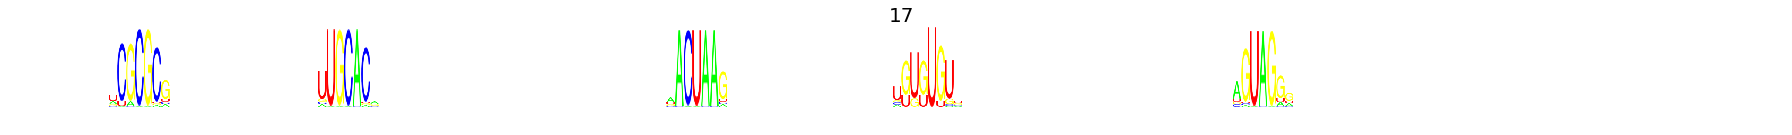

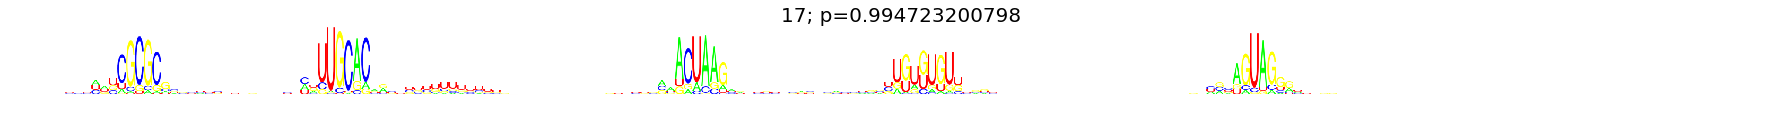

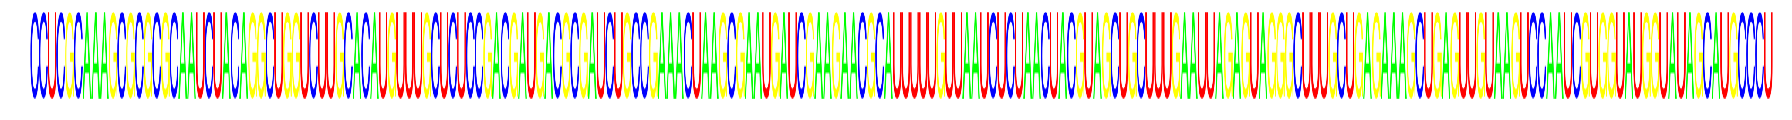

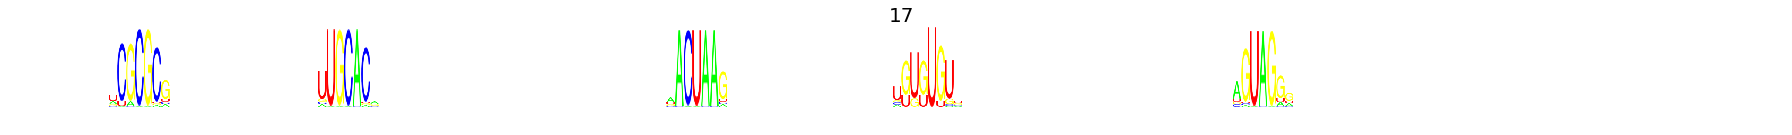

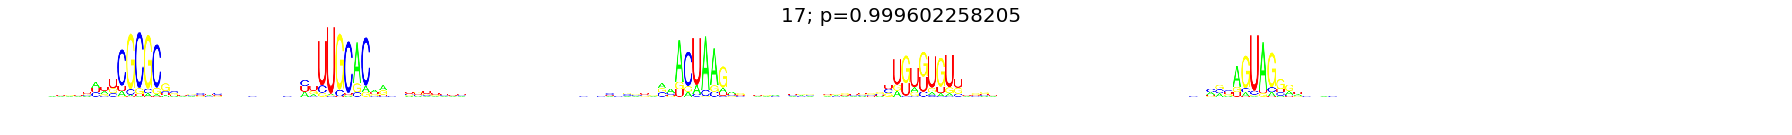

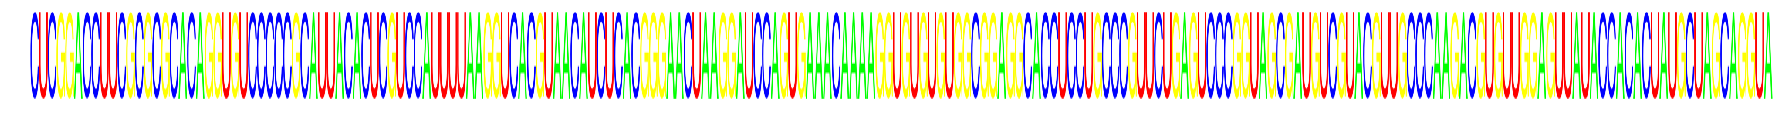

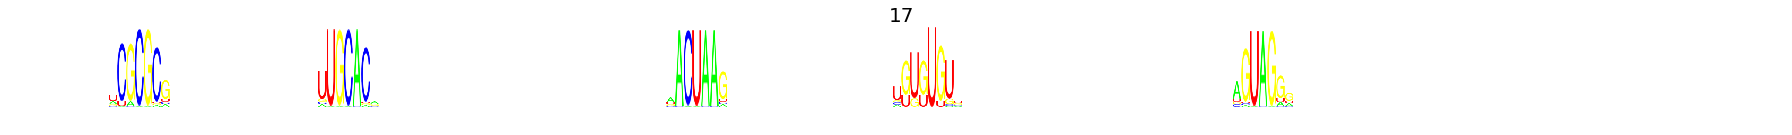

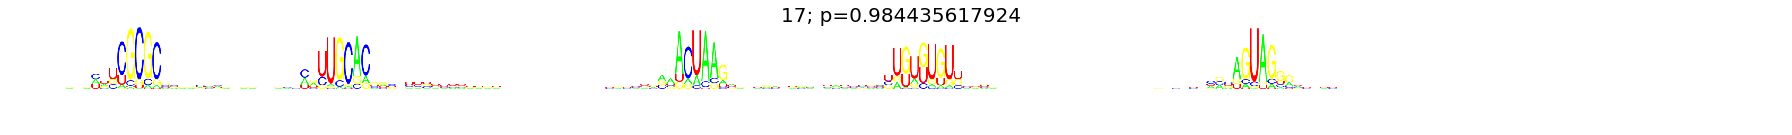

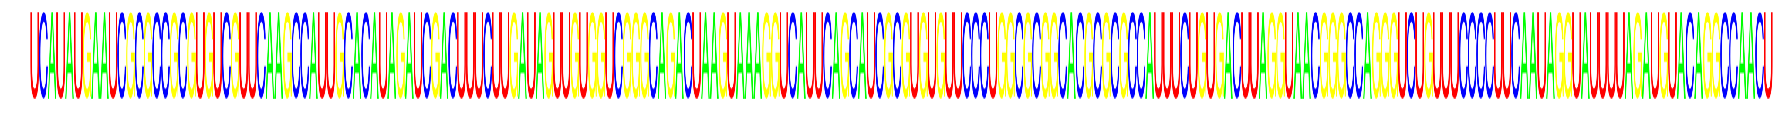

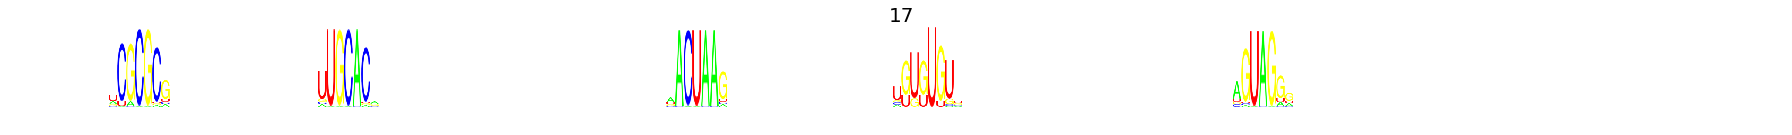

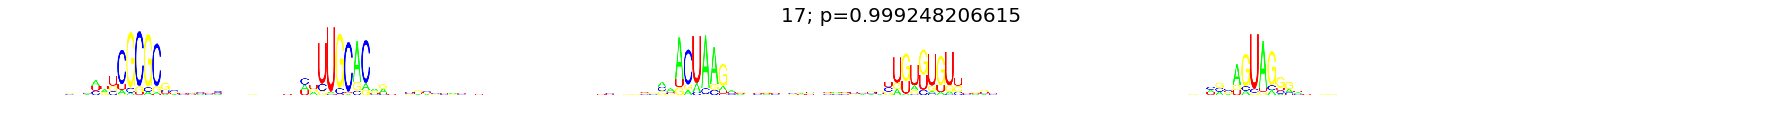

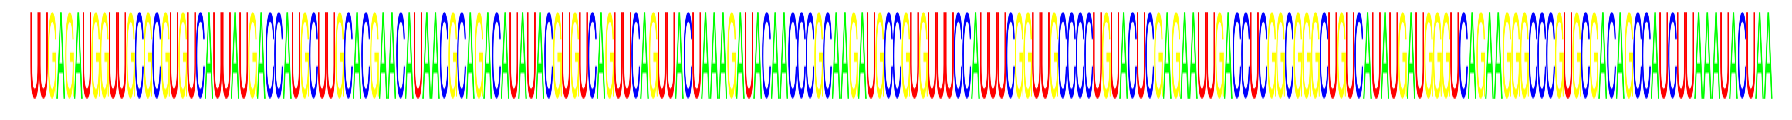

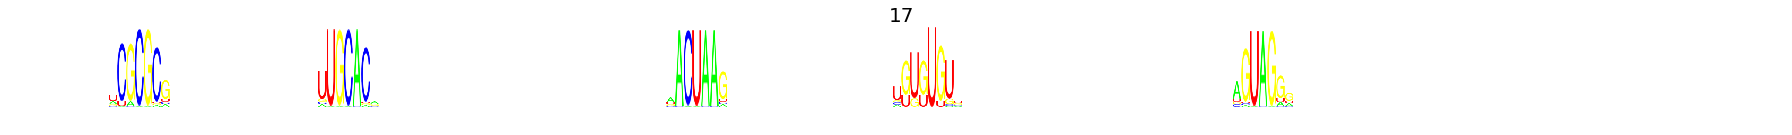

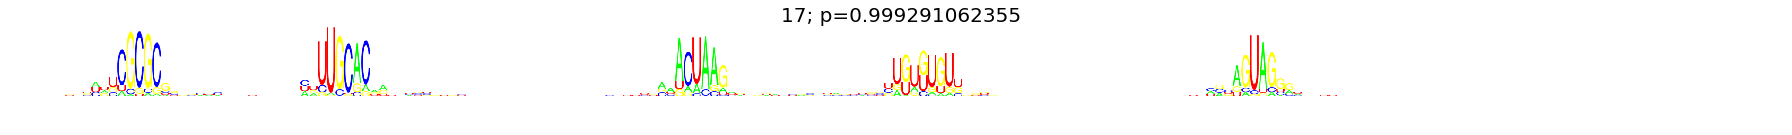

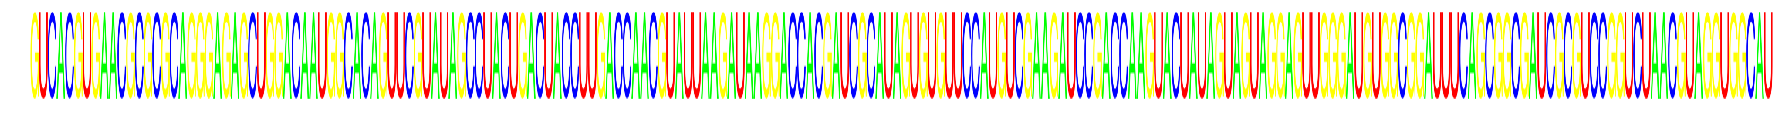

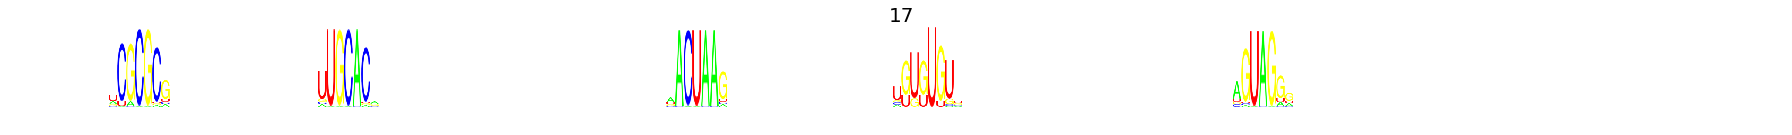

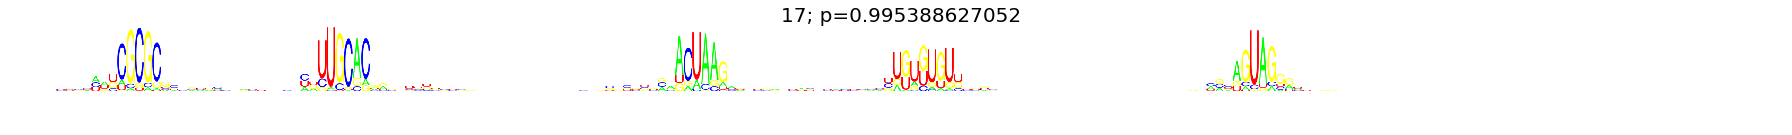

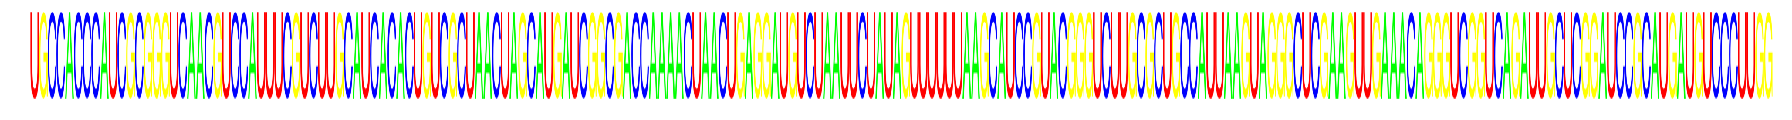

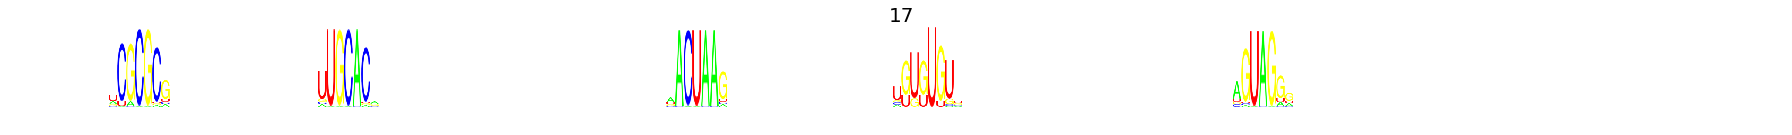

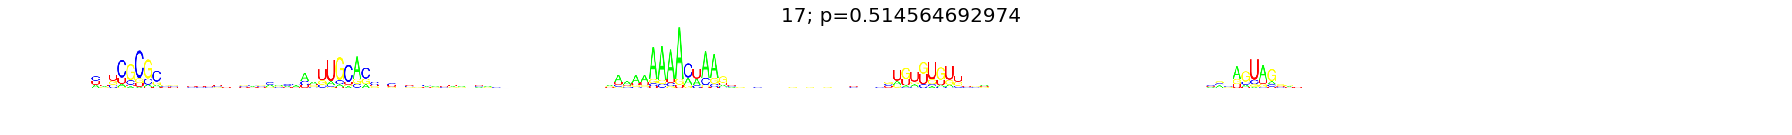

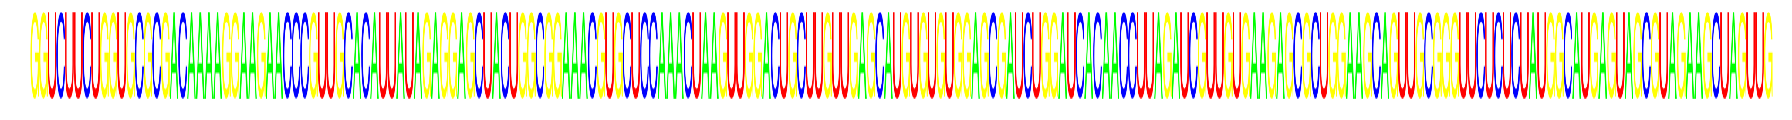

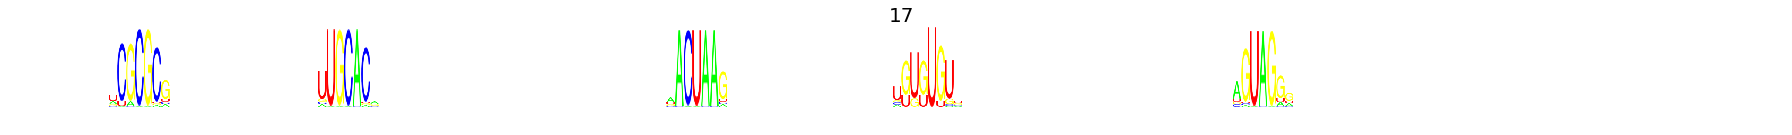

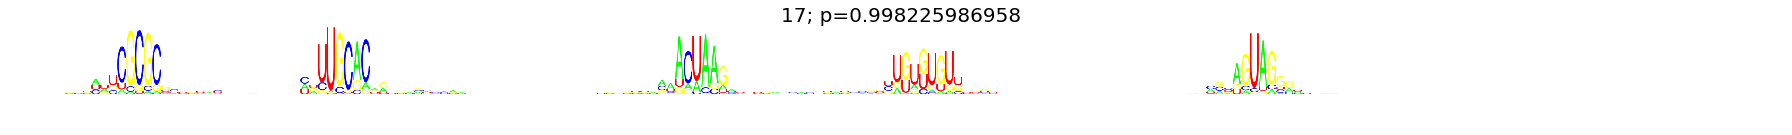

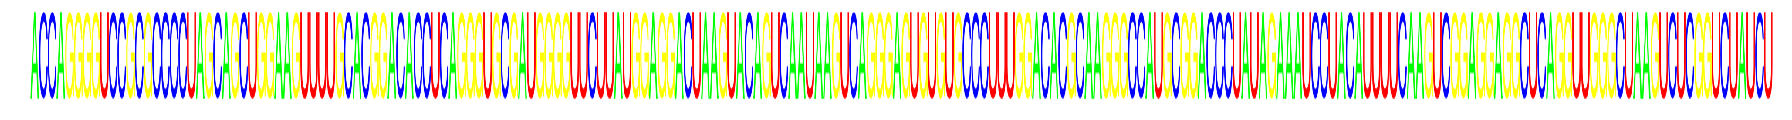

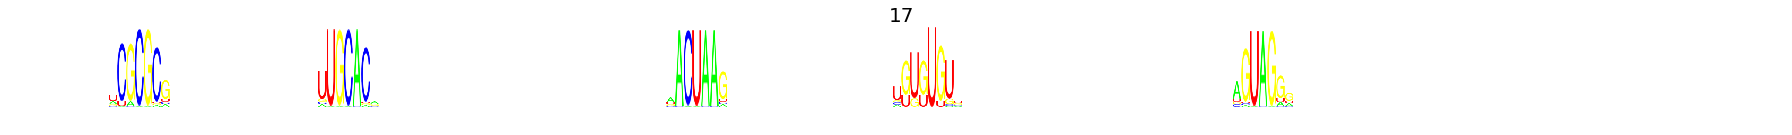

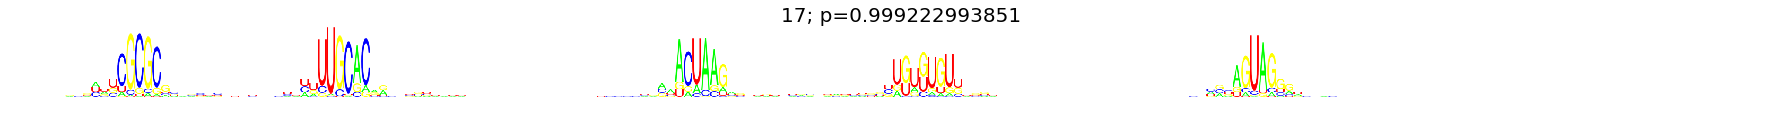

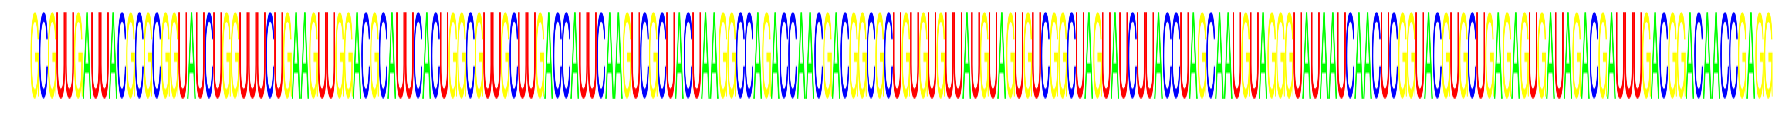

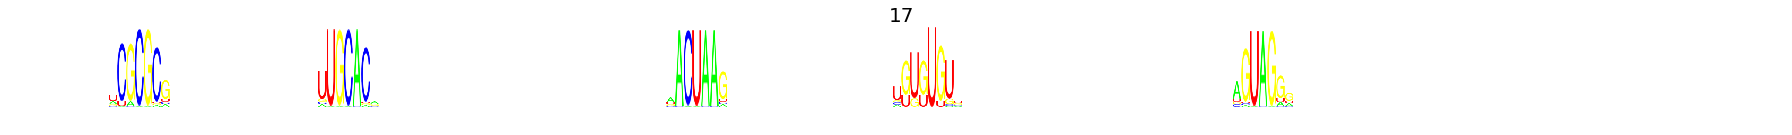

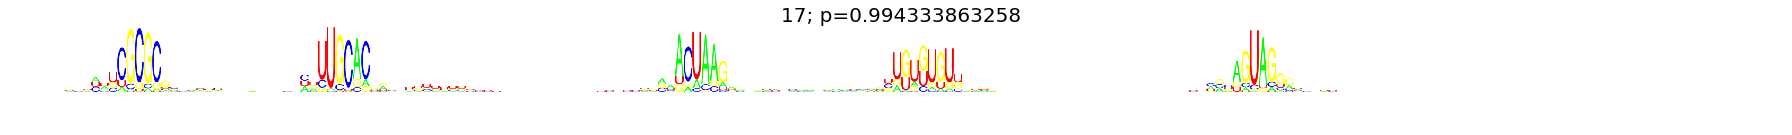

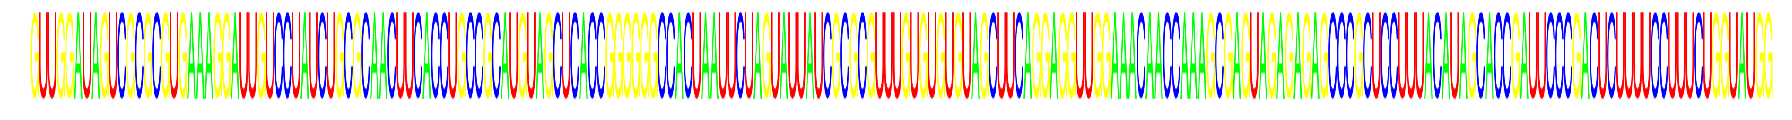

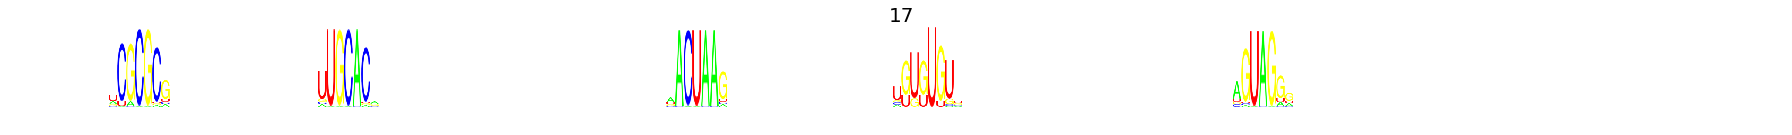

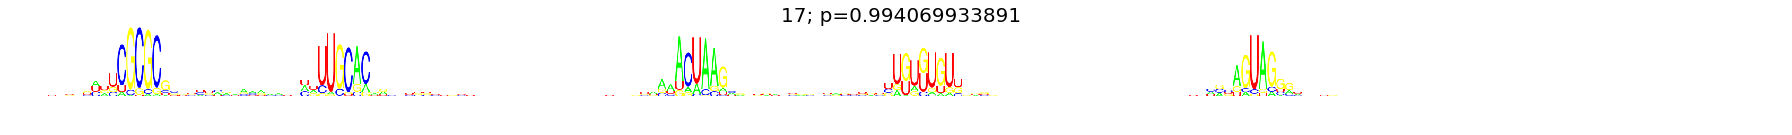

In [121]:
prediction = layers.get_output(deconv['output'], deterministic=False)
test_fun = theano.function([input_var2], prediction)

class_index = 17

labels = np.argmax(test[1],axis=1)
map_index = np.where(labels == class_index)[0]
for index in map_index[:20]:
    
    y = np.expand_dims(output2[index,:],0)
    prediction = test_fun(y.astype(np.float32))
    class_index = np.argmax(test[1][index,:])

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)

    logo = seq_logo(np.squeeze(prediction[0]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(np.argmax(output2[index,:]))+'; p='+str(np.max(output2[index,:])),fontsize=20)


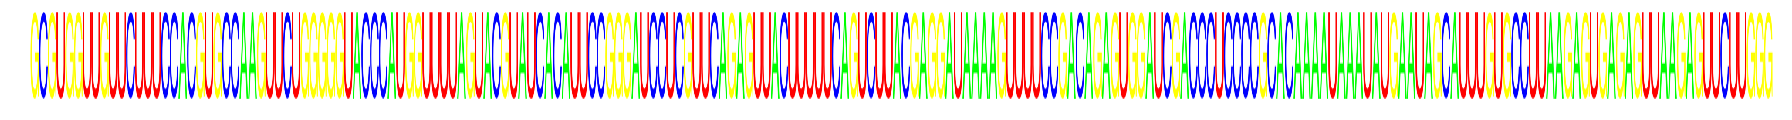

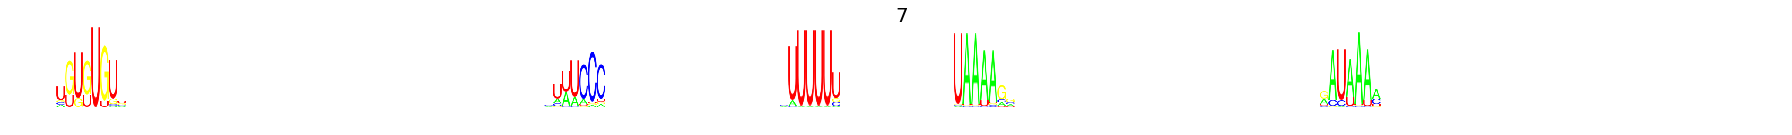

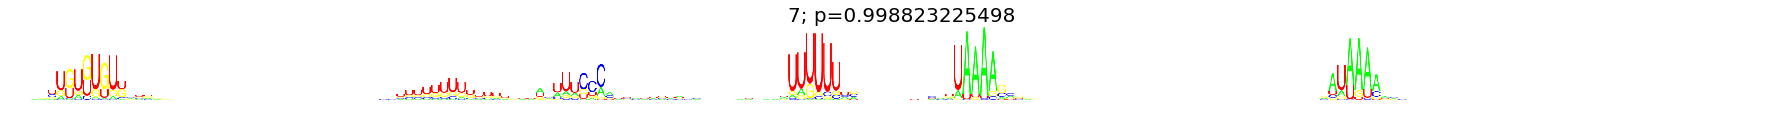

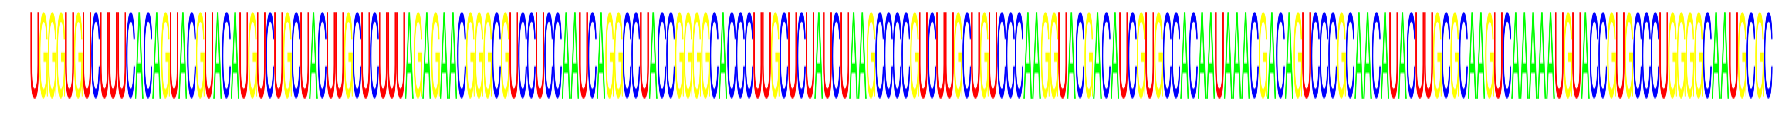

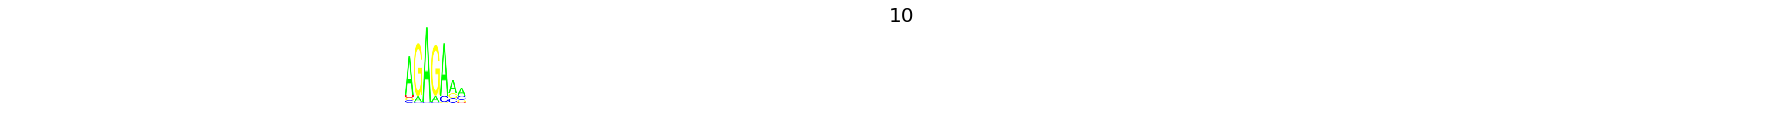

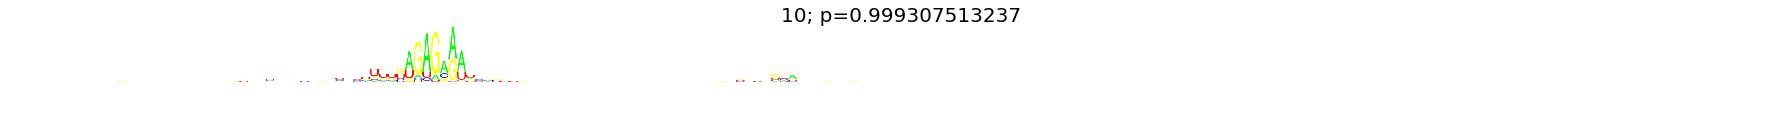

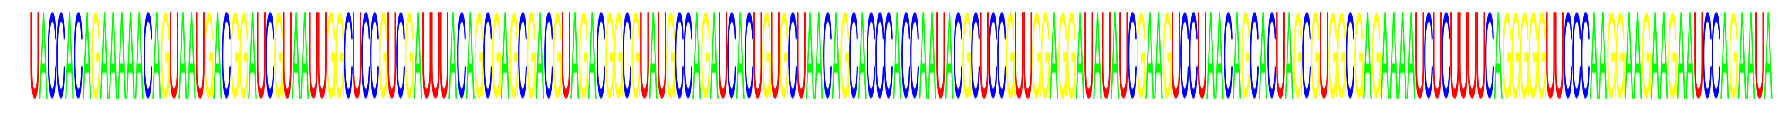

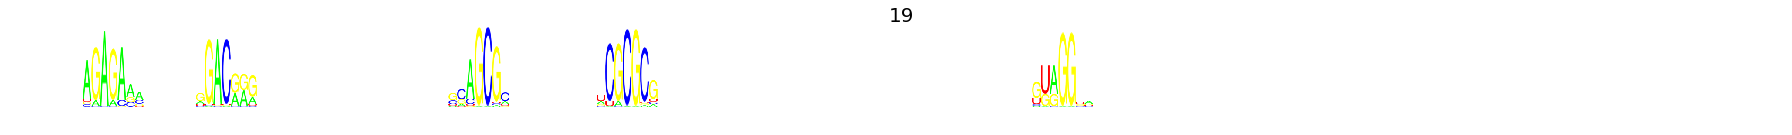

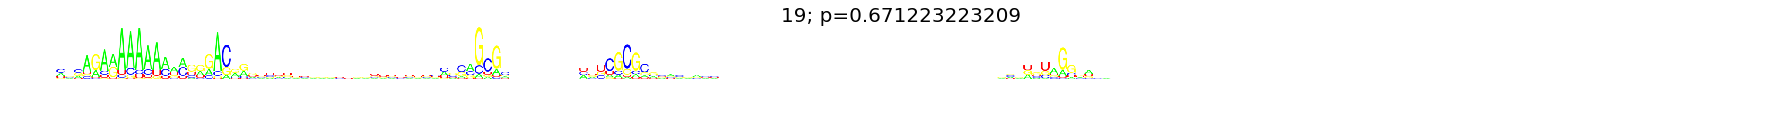

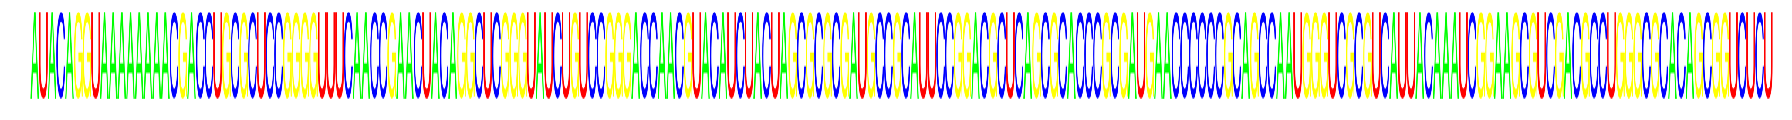

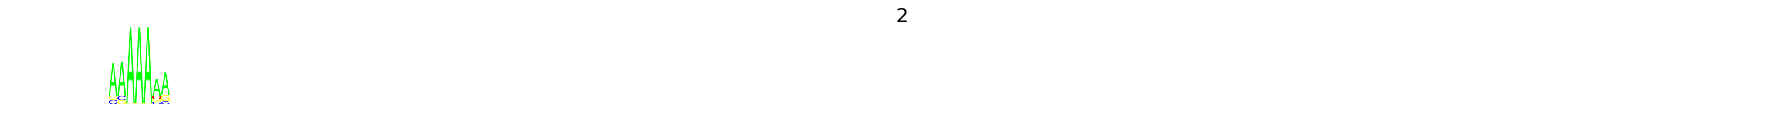

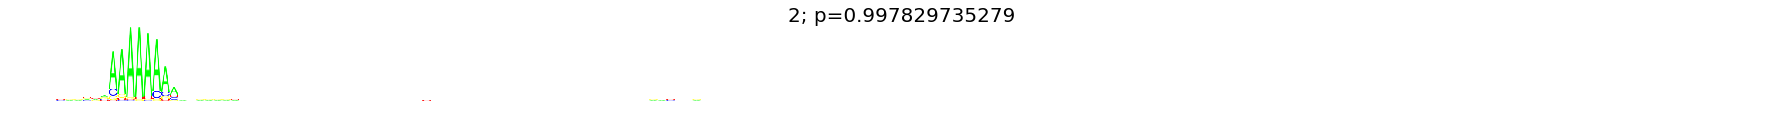

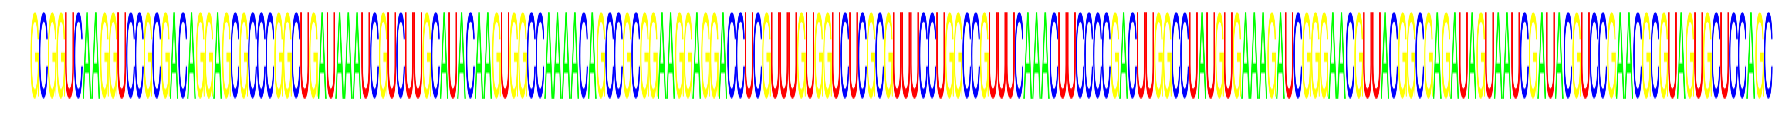

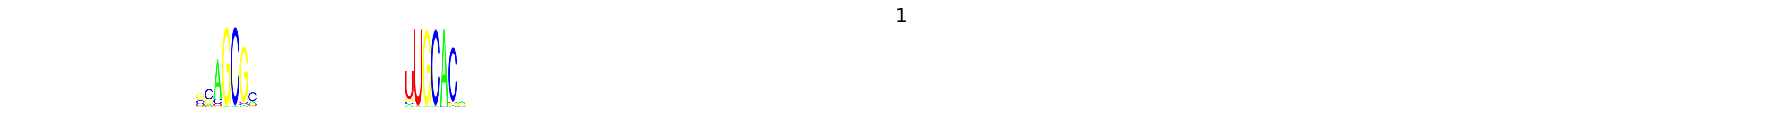

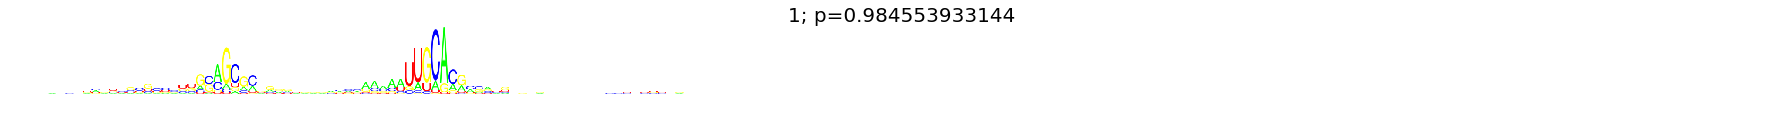

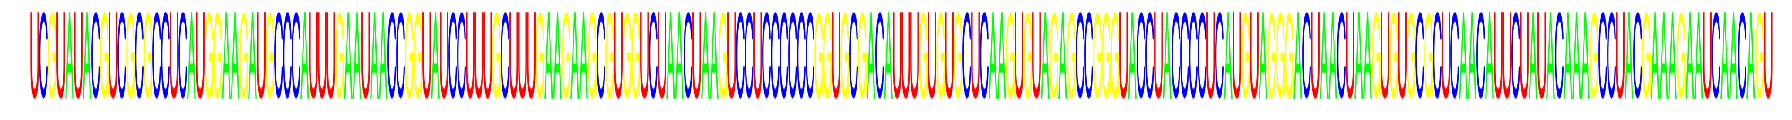

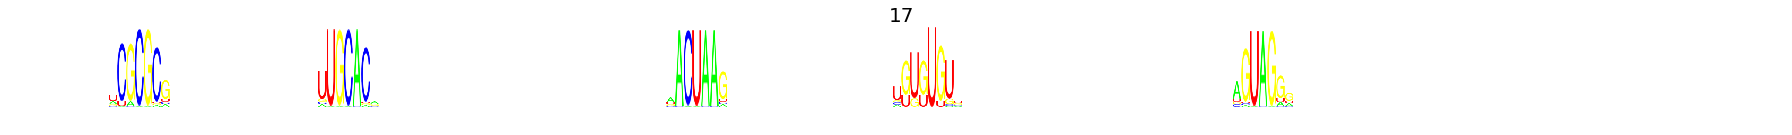

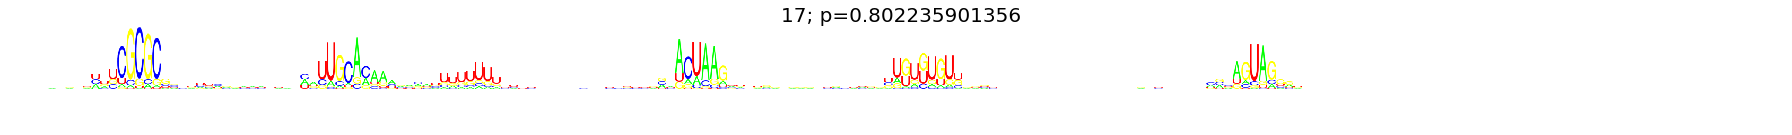

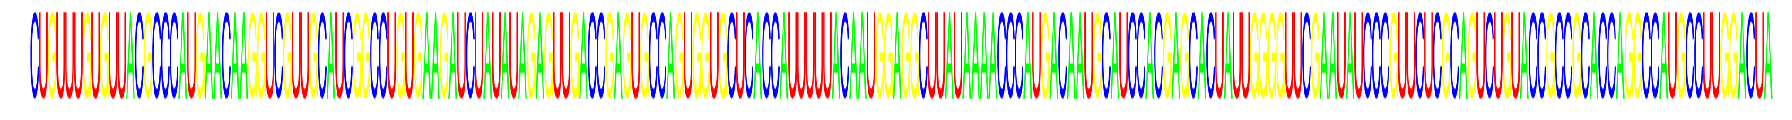

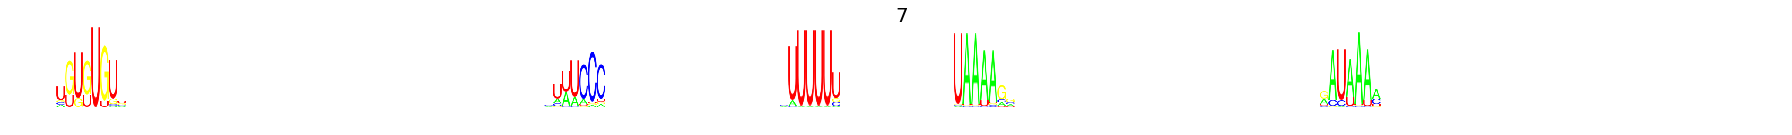

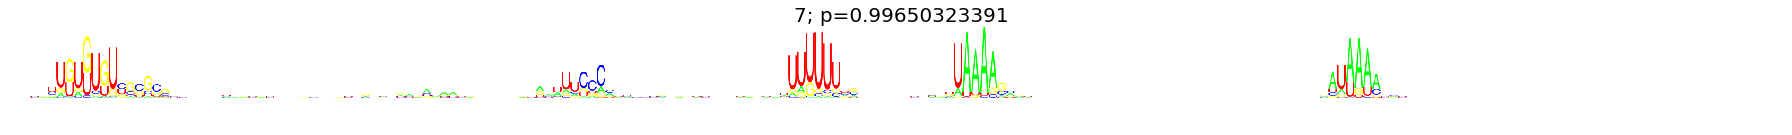

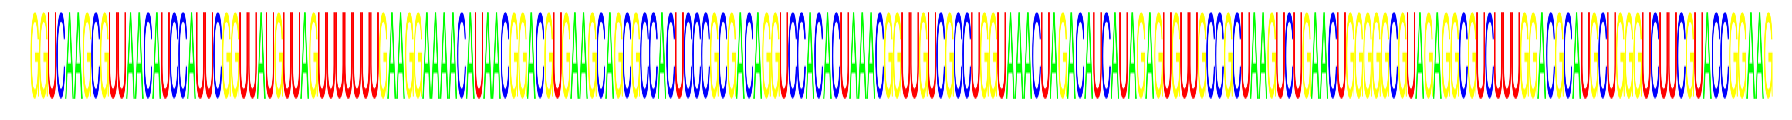

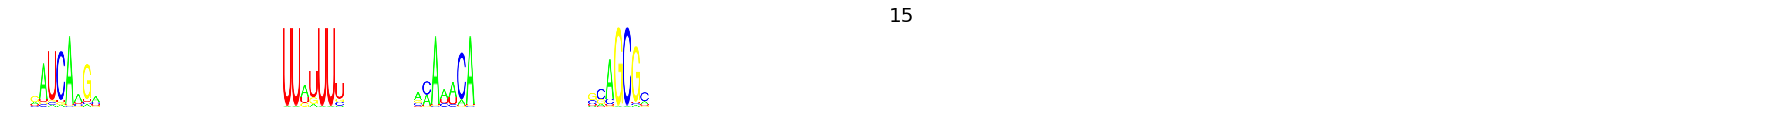

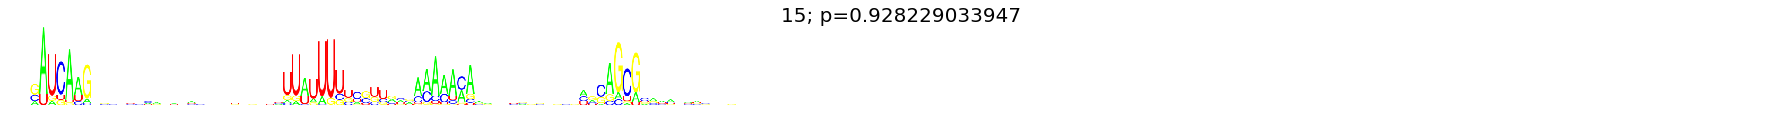

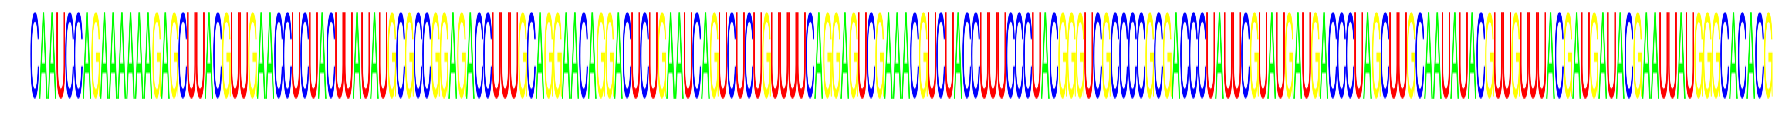

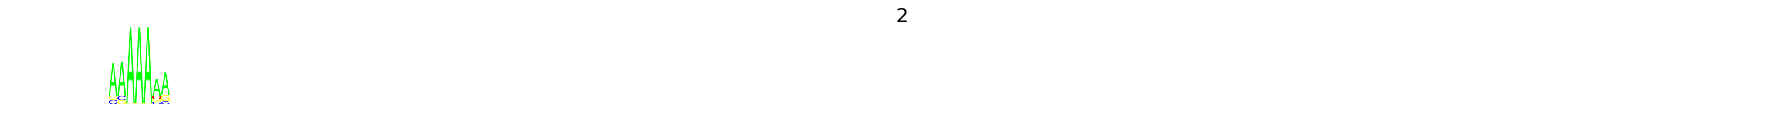

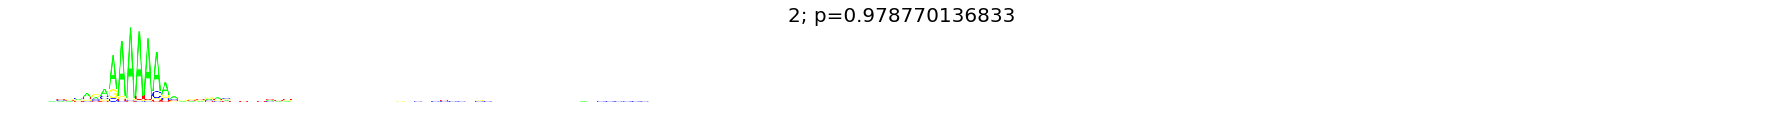

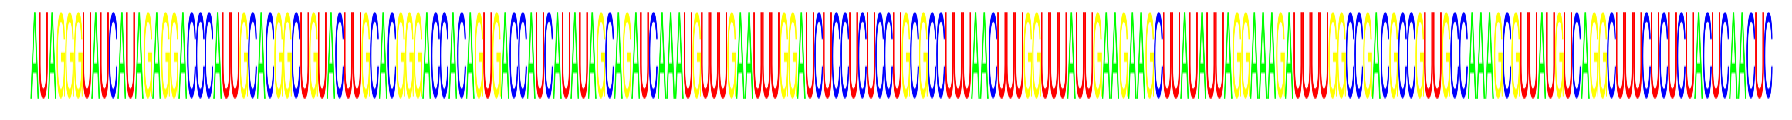

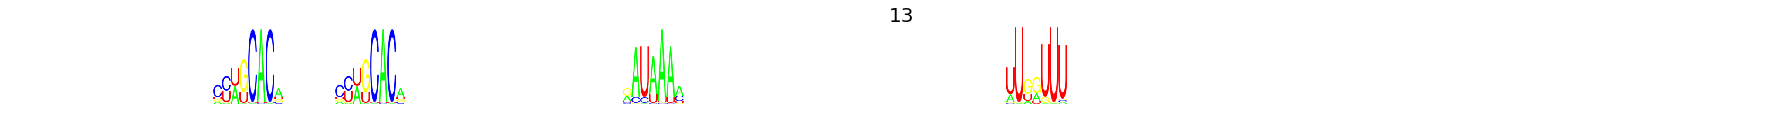

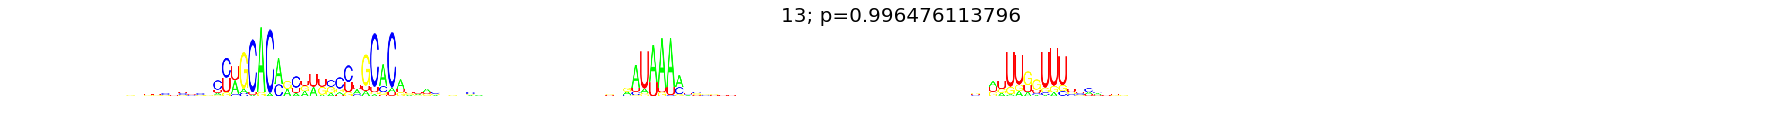

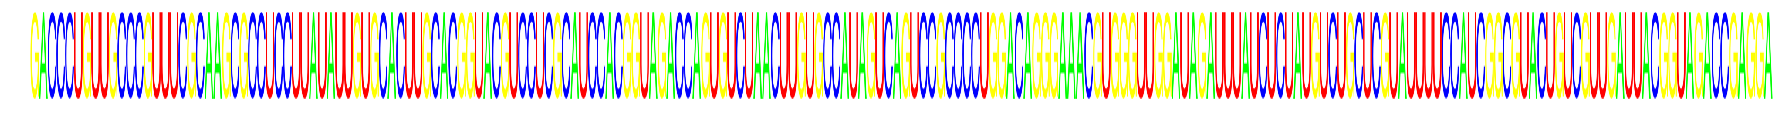

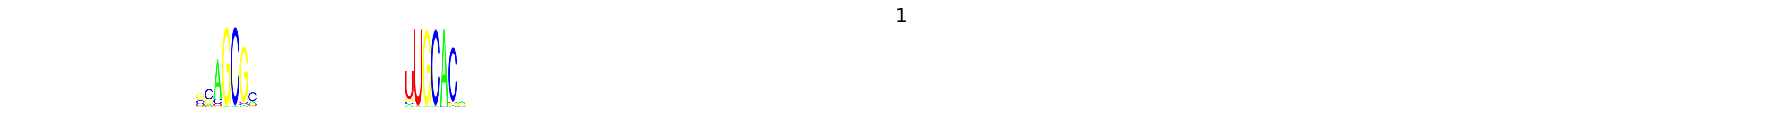

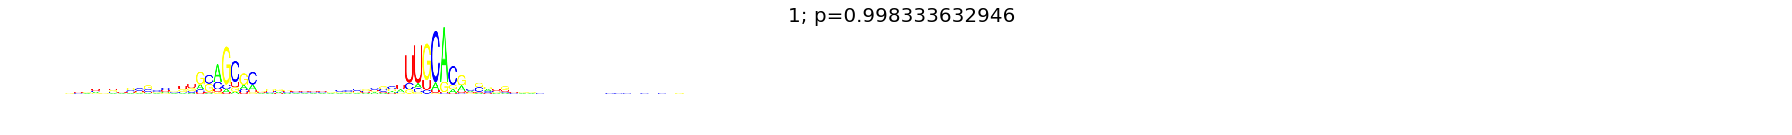

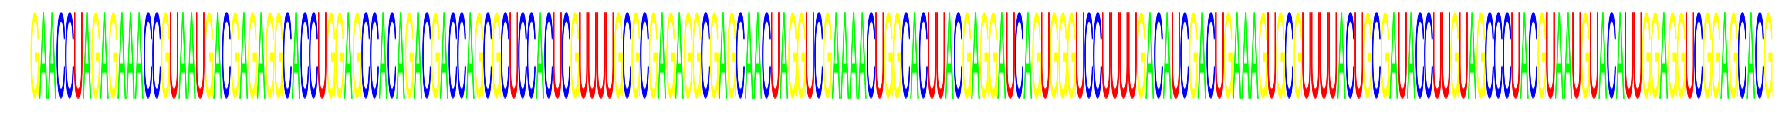

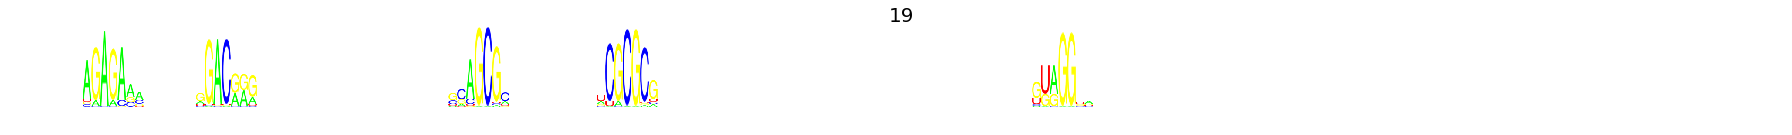

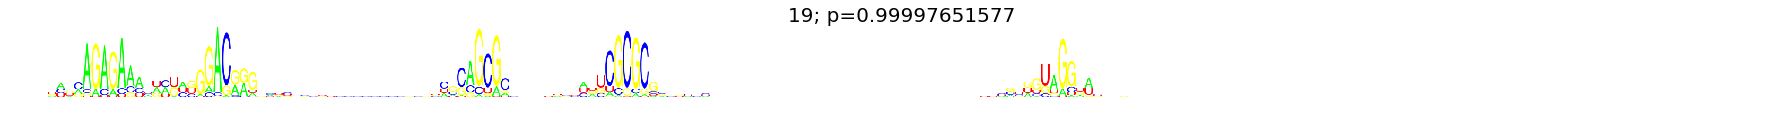

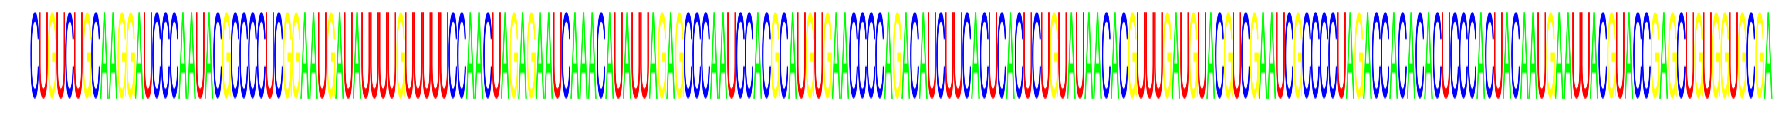

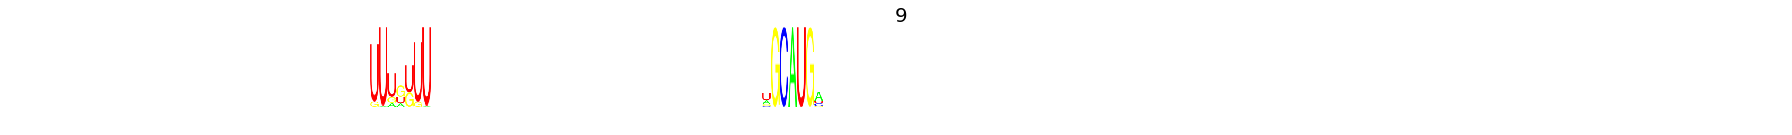

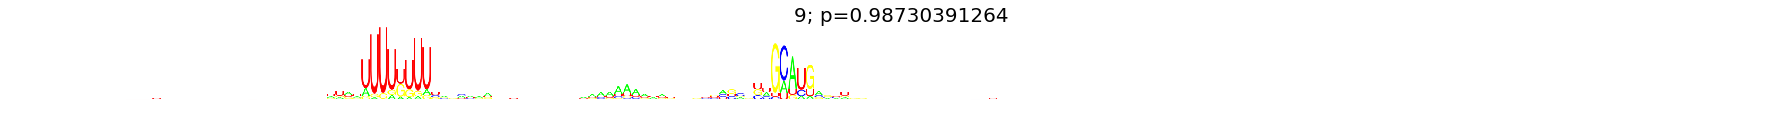

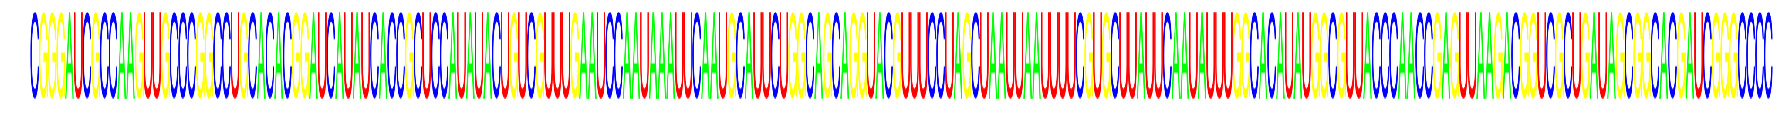

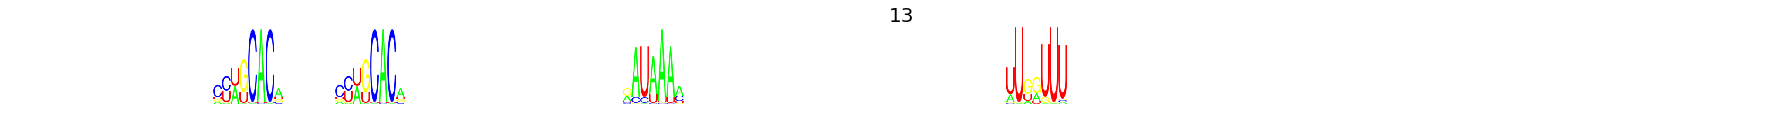

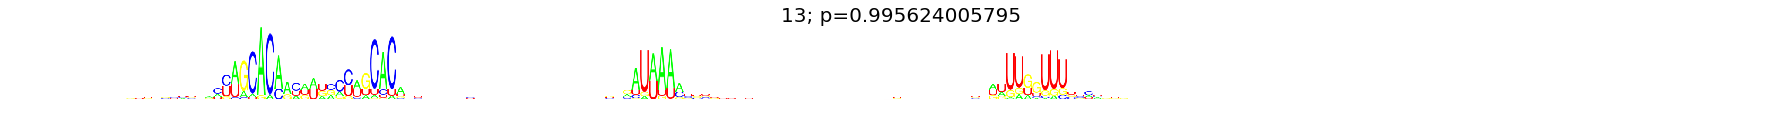

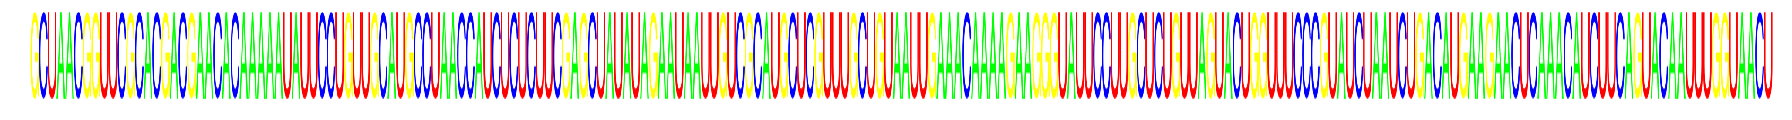

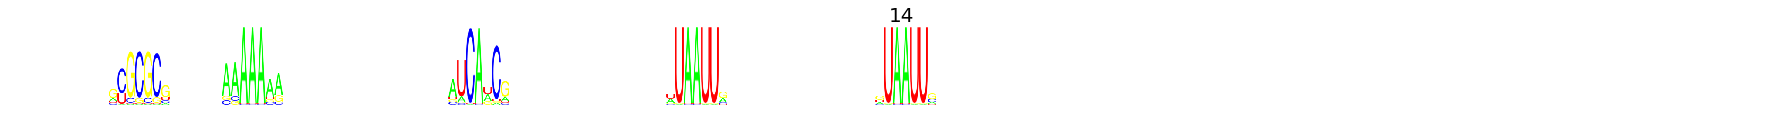

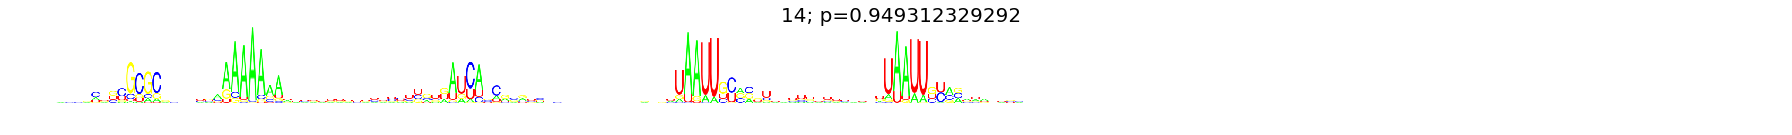

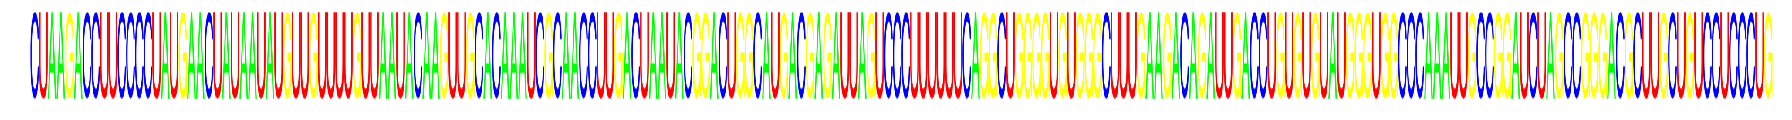

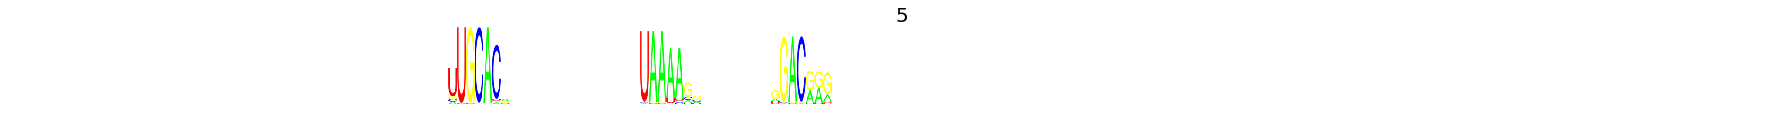

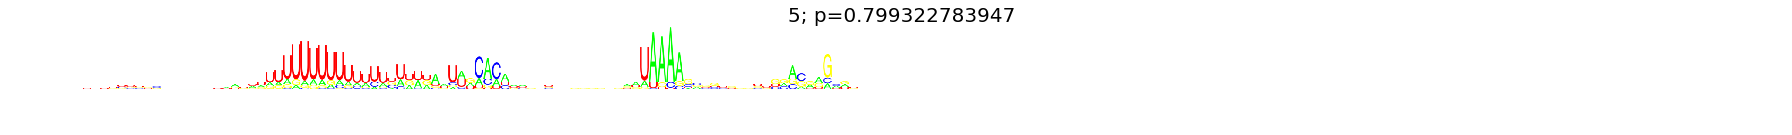

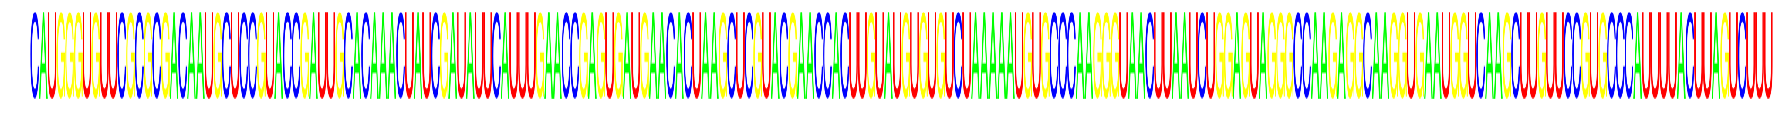

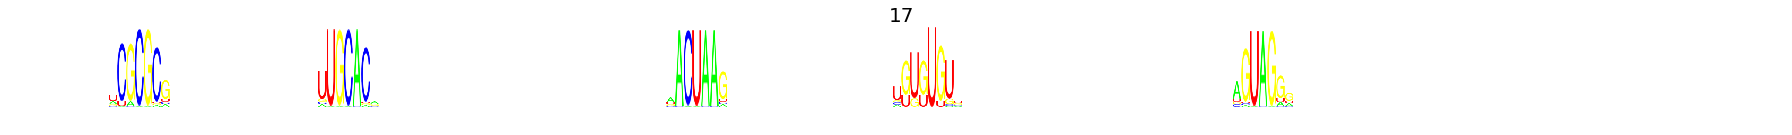

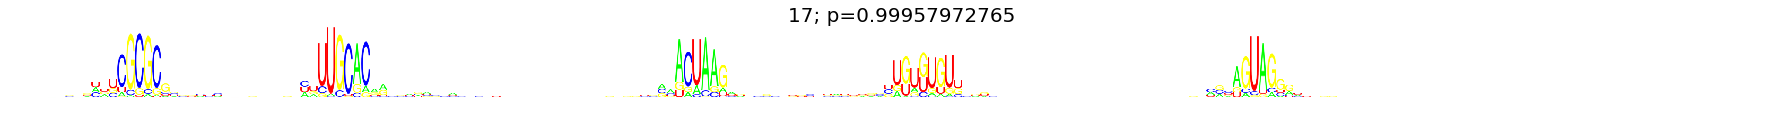

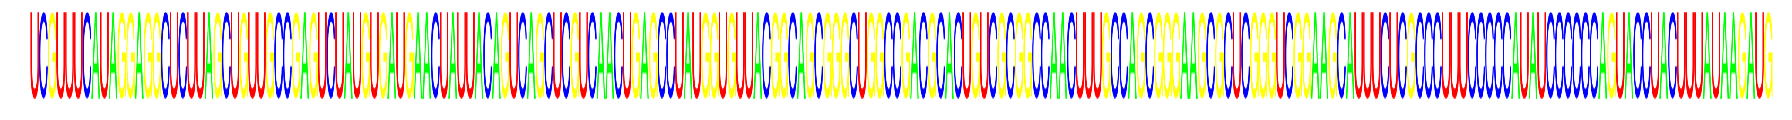

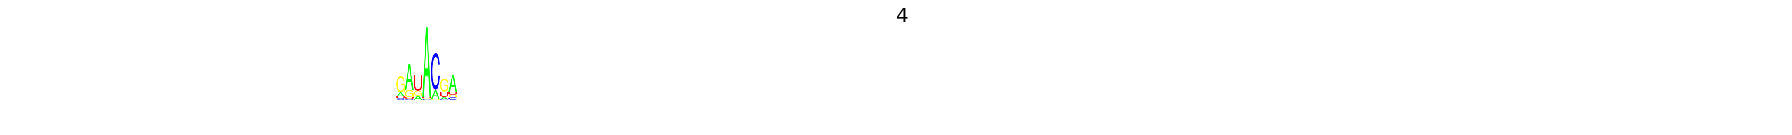

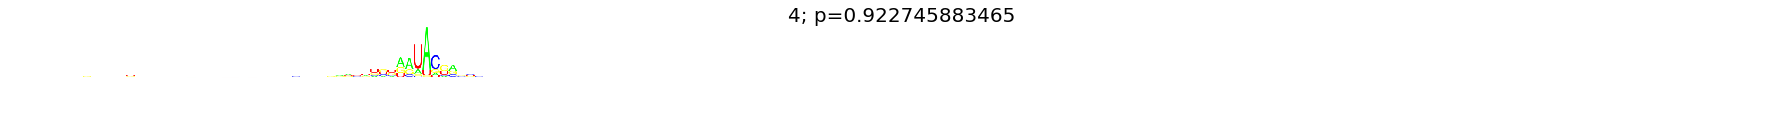

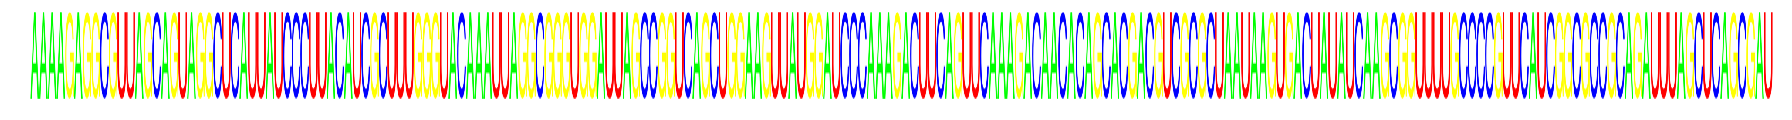

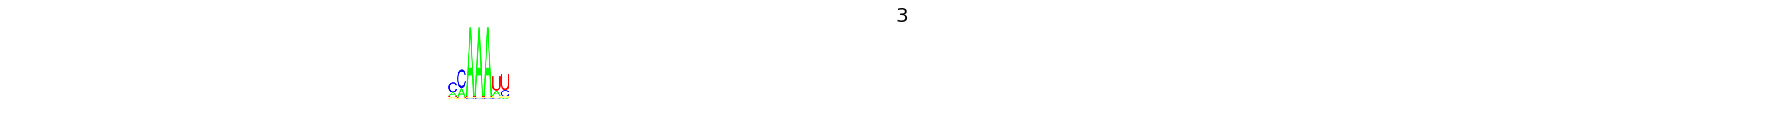

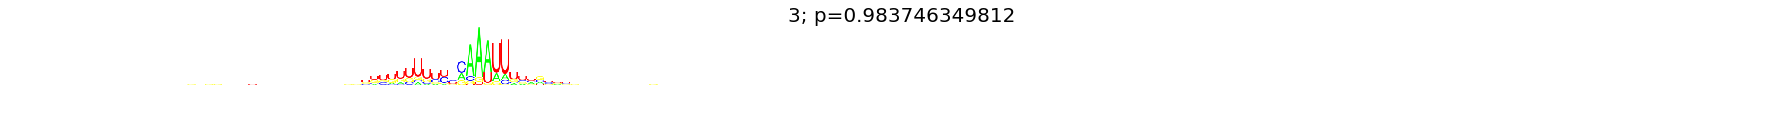

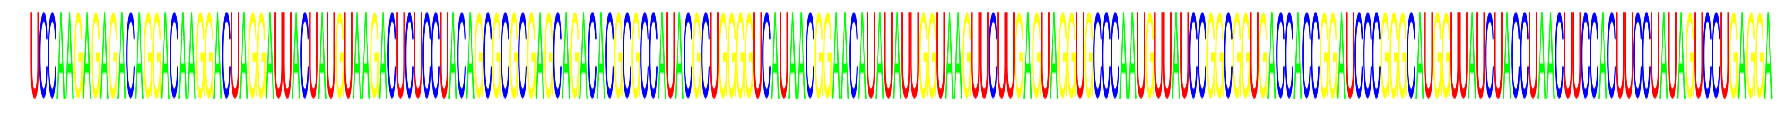

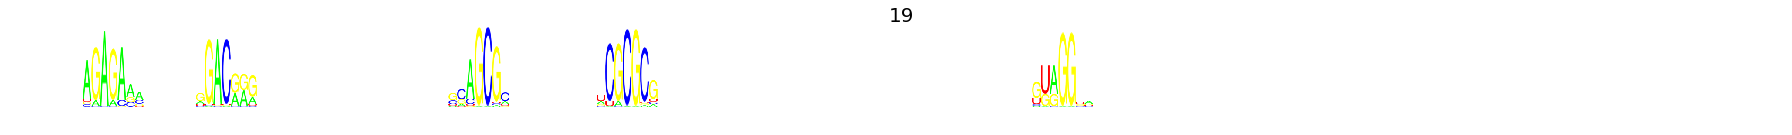

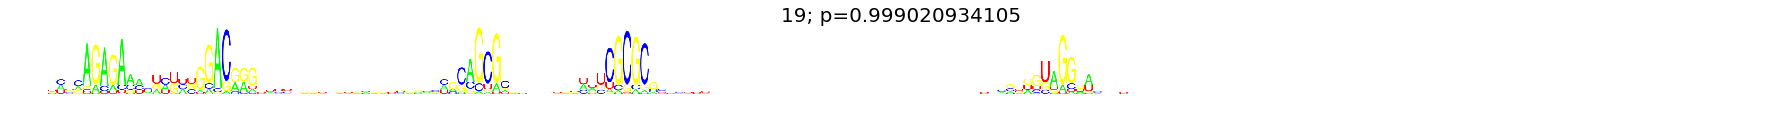

In [36]:
prediction = layers.get_output(deconv['output'], deterministic=False)
test_fun = theano.function([input_var2], prediction)


for index in range(40,60):

    y = np.expand_dims(output2[index,:],0)
    prediction = test_fun(y.astype(np.float32))
    class_index = np.argmax(test[1][index,:])

    height=100
    bp_width=20
    size = (25.,10.0)

    logo = seq_logo(np.squeeze(test[0][index]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');

    logo = seq_logo(test[2][index], height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(class_index),fontsize=20)

    logo = seq_logo(np.squeeze(prediction[0]), height, bp_width, norm=0, rna=1, filepath='.')
    fig = plt.figure(figsize=size);
    plt.imshow(logo, interpolation='none');
    plt.axis('off');
    plt.title(str(np.argmax(output2[index,:]))+'; p='+str(np.max(output2[index,:])),fontsize=20)


In [83]:
savename = 'unlocalized'

0

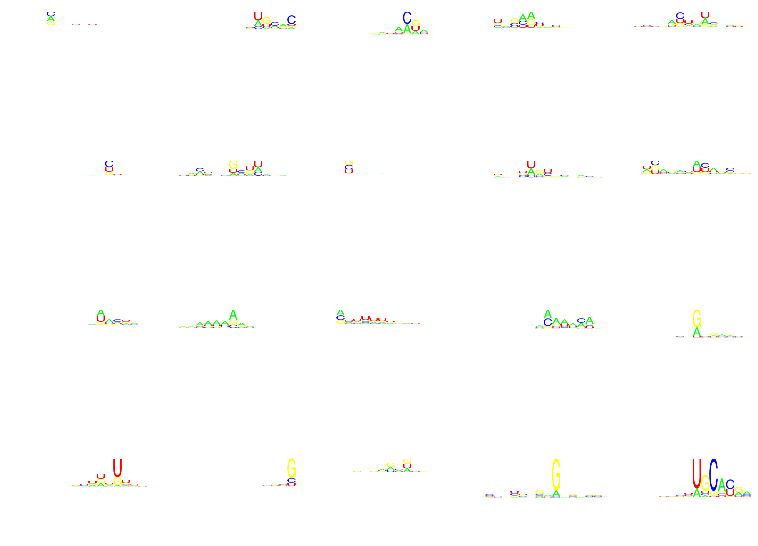

In [104]:
def plot_conv_filter(layer,size):
    W =  np.squeeze(layer.W.get_value())
    num_filters = W.shape[0]

    num_rows = int(np.ceil(np.sqrt(num_filters)))    
    grid = mpl.gridspec.GridSpec(num_rows, num_rows)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    
    fig = plt.figure(figsize=size);
    for i in range(num_filters):
        MIN = np.min(W[i])
        MAX = np.max(W[i])
        pwm = (W[i] - MIN)#/(MAX-MIN)
        norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
        pwm = pwm/norm

        logo = seq_logo(pwm, height=100, nt_width=25, norm=0, rna=1, filepath='.')
        plt.subplot(grid[i]);
        plt.imshow(logo);
        plt.axis('off');
    return fig, plt
%config InlineBackend.close_figures = False
fig, plt = plot_conv_filter(network['conv1'],size=(100.,100.))
fig.set_size_inches(100,100)

outfile = savename +'_filter1.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
call(['pdfcrop', outfile, outfile])

In [116]:
X = test[0]
input_var = nnmodel.input_var
layer = network['conv1_active']

# setup theano function to get feature map of a given layer
num_data = len(X)
feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
map_shape = get_output_shape(layer)

# get feature maps in batches for speed (large batches may be too much memory for GPU)
num_batches = num_data // batch_size
shape = list(map_shape)
shape[0] = num_data
fmaps = np.empty(tuple(shape))
for i in range(num_batches):
    index = range(i*batch_size, (i+1)*batch_size)    
    fmaps[index] = feature_maps(X[index])

# get the rest of the feature maps
excess = num_data-num_batches*batch_size
index = range(num_data-excess, num_data)    
fmaps[index] = feature_maps(X[index])


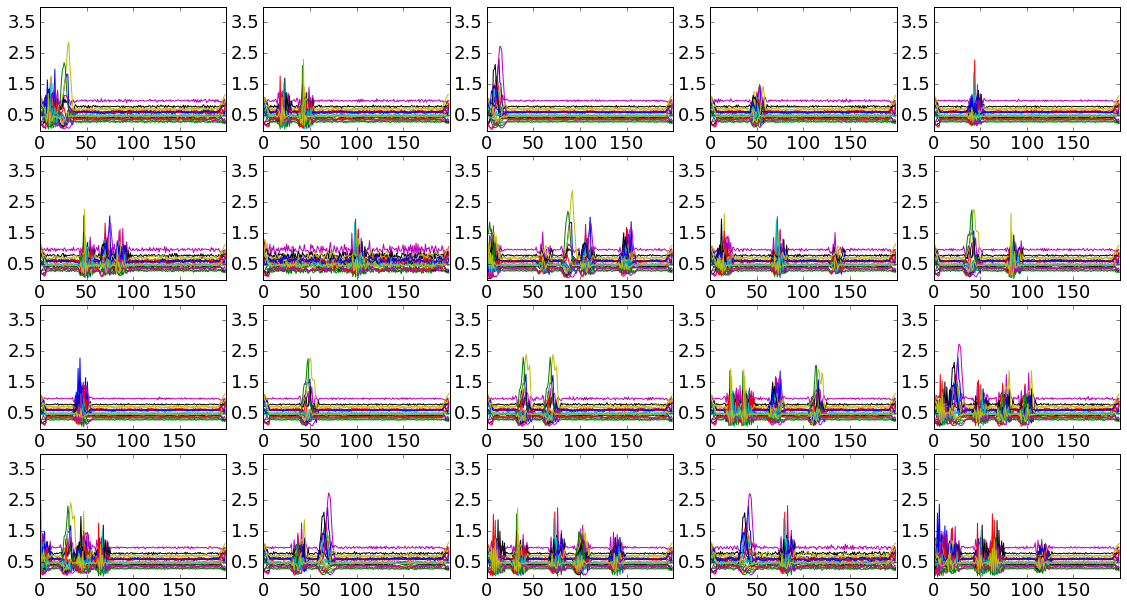

In [119]:

def get_class_activation(fmaps, y, batch_size=512):
    fmaps = np.squeeze(fmaps)
    mean_activation = []
    std_activation = []
    for i in range(max(y)+1):
        index = np.where(y == i)[0]
        mean_activation.append(np.mean(fmaps[index], axis=0))
        std_activation.append(np.std(fmaps[index], axis=0))
    return np.array(mean_activation), np.array(std_activation)


def plot_mean_activations(mean_activation, options):
    num_labels = len(mean_activation)
    nrows = np.ceil(np.sqrt(num_labels)).astype(int)
    ncols = nrows

    plt.figure()
    grid = mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    
    for i in range(num_labels):
        plt.subplot(grid[i])
        plt.plot(mean_activation[i].T)
        fig_options(plt, options)
    return plt

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

        
mean_activation, std_activation = get_class_activation(fmaps, np.argmax(test[1],axis=1))
options = { 'ylim': [0, 4],
            'xticks': [0, 50, 100, 150],
            'yticks': [0.5, 1.5, 2.5, 3.5], 
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)
#plt.savefig('categorical_l1_activation.eps', format='eps', dpi=1000)    